<a href="https://colab.research.google.com/github/Bruno-Messias/data_science_visagio/blob/main/Aprendizado_Nao_Supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Métodos de Aprendizado não Supervisionado</center>

<a id="recap"></a>
## 1. Introdução

Nos capítulos anteriores, exploramos conceitos iniciais de ML, numpy/pandas e uma introdução a algumas das técnicas de EDA. Neste capítulo, vamos nos concentrar em uma abordagem diferente de ML: a **Aprendizagem não Supervisionada**. Mais especificamente, vamos nos aprofundar nas principais técnicas e algoritmos utilizados para abordar este tópico, explorando as armadilhas mais comuns que esse tipo de problema traz, como implementar esse tipo de algoritmo usando Python e como avaliar e selecionar o melhor modelo para seu problema.

> **Recapitulação da definição**: a principal diferença entre os tipos não supervisionado e supervisionado é que o **Aprendizado supervisionado** é feito utilizando um conhecimento prévio da variável resposta, ou em outras palavras, temos conhecimento prévio de quais devem ser os valores de saída de nossos modelos. Portanto, o objetivo da aprendizagem supervisionada é aprender uma função que, dada uma amostra de dados e saídas desejadas, melhor as correlacione. A **Aprendizagem não Supervisionada**, por outro lado, não possui saídas rotuladas, então seu objetivo é inferir a estrutura natural presente dentro de um conjunto de dados. As tarefas mais comuns na aprendizagem não supervisionada são a clusterização e a análise de associação. O aprendizado não supervisionado também é muito utilizado na análise exploratória já que é capaz de identificar agrupamentos ou similaridade entre as instâncias analisadas.

Para apresentar as técnicas de **Aprendizagem não Supervisionada** mais comuns, esta aula será dividida em 3 seções. A primeira apresenta a metodologia de Análise de Associação, útil para descobrir correleações ocultas em grandes conjuntos de dados. A segunda seção apresenta a Análise de Cluster, um grupo de técnicas que o ajudará a descobrir semelhanças entre instâncias. Por fim, teremos uma última seção que tratara sobre a técnica de Soft clustering.


<a id="association_analysis"></a>
## 2. Análise de Associação

<a id="problem_definition_association"></a>
### 2.1. Definição do Problema

Imagine a seguinte situação hipotética: você possui uma loja de varejo que vende produtos ao público em quantidades relativamente pequenas e percebeu que quase todos os clientes que compram fraldas também compram cervejas. Naturalmente, você se pergunta: _ "Nossa, que padrão estranho! Será que devo colocar os dois produtos lado a lado na prateleira ?" _. Bem, é um tipo de correlação estranha, mas imagine que você pudesse identificar padrões comuns em todos os itens vendidos por sua loja. Não seria interessante ?!

Infelizmente, esta história é provavelmente uma lenda urbana de dados. No entanto, é um exemplo ilustrativo (e divertido) dos insights que podem ser obtidos pela **Análise de associação**, que tenta encontrar padrões comuns sobre itens em grandes conjuntos de dados. Esta aplicação específica é frequentemente chamada de análise de cesta de compras (mais especificamente, este é o caso do "cerveja e fraldas"), mas também pode ser aplicada a outras situações, pedido de peças de reposição e mecanismos de recomendação online - apenas para citar um pouco.

Para apresentá-lo ao aprendizado de regras de associação, vamos examinar o Dataset chamado **Online Retail Data Set**, que contém todas as transações ocorridas entre 01/12/2010 e 09/12/2011 para um e-commerce.

In [1]:
# Usando outro caminho para obter os csv do google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -s /content/drive/MyDrive/Data\ Science/Entrega3 /mydrive
!ls /mydrive

'Aprendizado Nao Supervisionado.ipynb'	 dados


In [3]:
# Leitura do Dataset
import pandas as pd

df = pd.read_excel('/mydrive/dados/Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# É necessária uma primeira etapa de tratamento dos dados.
# Primeiramente, algumas das descrições possuem espaços que precisam ser removidos. 
# Além disso, também iremos remover linhas sem informação

df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

<a id="initial_analysis_association"></a>
### 2.2. Análises Iniciais

A Análise de Associação é relativamente simples em termos matemáticos. Esta técnica é um bom começo para certos casos de exploração de dados e pode apontar o caminho para uma análise mais profunda nos dados utilizando outras abordagens.

Mas antes de começarmos a modelar nosso problema, há alguns termos usados na análise de associação que são fundamentais para sua compreenção: ***Itemset, Suporte, Confiança e Lift***. Nas próximas subseções, explicamos esses termos em detalhes, com base nas seguintes transações (Exemplificadas na imagem abaixo):

<img src="https://annalyzin.files.wordpress.com/2016/04/association-rule-support-table.png?w=376&h=334" width="350">


#### 2.2.1 Itemset
A Análise de Associação tenta identificar associações frequentes "se-então" chamadas regras de associação, que consistem em um antecedente (se) e um consequente (então). Para uma determinada regra, chamamos ***Itemset*** a lista de todos os itens no antecedente e no consequente. Por exemplo: “Se maçã e cerveja, arroz” (“Se maçã e cerveja forem comprados, então há uma grande chance de que arroz também seja comprado pelo cliente”). Nesse caso, maçã e cerveja são o antecedente e o arroz é o consequente.

#### 2.2.2 Suporte

Isso mostra a popularidade de um conjunto de itens, medido pela proporção de transações nas quais um conjunto de itens aparece. Na tabela mostrada acima, o suporte de {Maçã} é 4 de 8, ou 50%. Os conjuntos de itens também podem conter vários itens. Por exemplo, o suporte de {maçã, cerveja, arroz} é 2 de 8, ou 25%.

![img](https://annalyzin.files.wordpress.com/2016/03/association-rule-support-eqn.png?w=186&h=51)

Se você descobrir que as vendas de itens além de uma determinada proporção tendem a ter um impacto significativo em seus lucros, você pode considerar usar essa proporção como seu limite de suporte.

#### 2.2.3 Confiança

Isso indica a probabilidade de compra do item Y quando o item X é comprado, expressa como {X -> Y}. Isso é medido pela proporção de transações com o item X, em que o item Y também aparece. Na Tabela 1, a confiança de {Maçã -> Cerveja} é 3 de 4, ou 75%.

![img](https://annalyzin.files.wordpress.com/2016/03/association-rule-confidence-eqn.png?w=394&h=57)

Uma desvantagem da medida de confiança é que ela pode representar mal a importância de uma associação. Isso ocorre porque ela só explica a popularidade das maçãs, mas não das cervejas. Se as cervejas também forem muito populares em geral, haverá uma chance maior de que uma transação contendo maçãs também contenha cervejas, aumentando assim a medida de confiança.

#### 2.2.4 Lift

Isso diz a probabilidade de o item Y ser comprado quando o item X é comprado, enquanto controla a popularidade do item Y. Na tabela mostrada acima, o Lift de {maçã -> cerveja} é 1, o que não implica nenhuma associação entre os itens. Um valor de Lift maior que 1 significa que o item Y provavelmente será comprado se o item X for comprado, enquanto um valor inferior a 1 significa que o item Y provavelmente não será comprado se o item X for comprado.

![img](https://annalyzin.files.wordpress.com/2016/03/association-rule-lift-eqn.png?w=424&h=60)

<a id="modeling_association"></a>
### 2.3. Modelagem

#### 2.3.1 Apriori

Apriori é um algoritmo popular para extrair conjuntos de itens frequentes com aplicações no aprendizado de regras de associação. Para grandes conjuntos de dados, pode haver centenas de itens em centenas de milhares de transações. O algoritmo a priori tenta extrair regras para cada combinação possível de itens. Por exemplo, o Lift pode ser calculado para o item 1 e item 2, item 1 e item 3, item 1 e item 4 e, em seguida, item 2 e item 3, item 2 e item 4 e, em seguida, combinações de itens, por exemplo item 1, item 2 e item 3; da mesma forma, item 1, item2 e item 4 e assim por diante.

O algoritmo a priori foi projetado para operar em bancos de dados contendo transações, como compras de clientes de uma loja. Um conjunto de itens é considerado "frequente" se atender a um limite de suporte especificado pelo usuário. Por exemplo, se o limite de suporte for definido como 0,5 (50%), um conjunto de itens frequente é definido como um conjunto de itens que ocorrem juntos em pelo menos 50% de todas as transações no banco de dados.

Para aplicar o algoritmo Apriori, utilizaremos a implementação python em [MLxtend](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/).

In [5]:
# Caso não possua, você deve instalar a biblioteca mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

A função implementada de MLxtend espera dados em um DataFrame pandas codificado no formato one-hot encoding. Isso significa que os itens de dados devem ser consolidados em uma transação por linha. Isso pode ser feito manualmente como ilustrado abaixo.

In [6]:
# Consolide os itens em 1 transação por linha.
# Para manter o conjunto de dados pequeno, analisaremos apenas as vendas para a França.
# obs.: uma outra maneira de fazer isto é usando o método pivot_table()
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket.head(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D DOG PICTURE PLAYING CARDS,3D HEARTS HONEYCOMB PAPER GARLAND,3D SHEET OF DOG STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,...,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537468,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Além disso, o algoritmo apriori só aceita números inteiros. Precisamos substituir todos os valores ≥1 por 1 e <1 por 0.

In [7]:
# Certifique-se de que todos os valores positivos sejam convertidos em 1 e qualquer valor menor que 0 seja definido como 0
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets.head(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D DOG PICTURE PLAYING CARDS,3D HEARTS HONEYCOMB PAPER GARLAND,3D SHEET OF DOG STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,...,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537468,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537897,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Agora que os dados estão estruturados corretamente, podemos gerar conjuntos de itens frequentes que têm um suporte de pelo menos 7% (esse número foi escolhido arbitrariamente).

In [8]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

Finalmente, podemos gerar as regras com seu suporte, confiança e lift correspondentes:

In [9]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
5,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
6,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.125000,0.099490,0.071429,0.571429,5.743590,0.058992,2.101190
7,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273
8,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.168367,0.137755,0.089286,0.530303,3.849607,0.066092,1.835747
9,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.137755,0.168367,0.089286,0.648148,3.849607,0.066092,2.363588


Bem, isso é tudo que há para fazer! Acabamos de construir os itens frequentes usando apriori e, em seguida, construir as regras com association_rules. Mas agora, a parte complicada é descobrir o que isso nos diz. Por exemplo, podemos ver que existem algumas regras com um alto Lift, o que significa que ocorre com mais frequência do que seria esperado, dado o número de combinações de transações e produtos.

### Exercicio 1

Use a célula abaixo para verificar as regras com aumento acima de 6 e confiança acima de 0,6. Que conclusões você consegue obter? Discuta

In [12]:
rules[(rules.confidence > 0.6)]
# Analizando os valores obtidos podmemos ver que objetos de papelaria costuman ser compradas muitas vezes em conjunto variando apenas as cores e os temas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135
5,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.094388,0.102041,0.073980,0.783784,7.681081,0.064348,4.153061
7,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.099490,0.125000,0.071429,0.717949,5.743590,0.058992,3.102273
9,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.137755,0.168367,0.089286,0.648148,3.849607,0.066092,2.363588
11,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.168367,0.170918,0.102041,0.606061,3.545907,0.073264,2.104592
12,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.170918,0.137755,0.104592,0.611940,4.442233,0.081047,2.221939


Além disso, não seria interessante ver como as combinações variam de acordo com o país de compra? Use a célula abaixo para verificar algumas combinações populares na Alemanha. Você consegue obter algum insight ?

In [16]:
basket = (df[df['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

#Analisando o obtido vemos que os suporte médio dos produtos na Alemanha parecem serem bem baixos, indicando que os clientes nesse paises diversificam bastante a compra de produtos.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.137856,0.245077,0.074398,0.539683,2.202098,0.040613,1.640006
1,(ROUND SNACK BOXES SET OF4 WOODLAND),(PLASTERS IN TIN WOODLAND ANIMALS),0.245077,0.137856,0.074398,0.303571,2.202098,0.040613,1.237951
2,(ROUND SNACK BOXES SET OF4 WOODLAND),(ROUND SNACK BOXES SET OF 4 FRUITS),0.245077,0.157549,0.131291,0.535714,3.400298,0.092679,1.814509
3,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.157549,0.245077,0.131291,0.833333,3.400298,0.092679,4.529540
4,(SPACEBOY LUNCH BOX),(ROUND SNACK BOXES SET OF4 WOODLAND),0.102845,0.245077,0.070022,0.680851,2.778116,0.044817,2.365427
5,(ROUND SNACK BOXES SET OF4 WOODLAND),(SPACEBOY LUNCH BOX),0.245077,0.102845,0.070022,0.285714,2.778116,0.044817,1.256018


<a id="clustering_analysis"></a>
## 3. Análise de Clusterização

Na seção anterior, apresentamos a metodologia de Análise de Associação, que é um dos métodos de Aprendizagem não Supervisionados mais comuns. Agora vamos apresentar a você outra técnica extremamente usada: a **Análise de Clusterização**.

<a id="problem_definition_clustering"></a>
### 3.1. Definição do Problema

Suponha que você esteja agora na seguinte situação hipotética: você ainda possui uma loja de varejo e depois de identificar padrões comuns de itens vendidos por sua loja, agora você gostaria de atingir grupos específicos de clientes com campanhas publicitárias específicas.

Para fazer isso, você se pergunta: _"Existe alguma maneira de identificar quais são os diferentes tipos de clientes que compram em minha loja, por exemplo, considerando as características de meus clientes, como histórico de compras, interesses ou monitoramento de atividades padrões?"_. Bem, neste caso, a Analise de Clusterização poderia definitivamente ajudá-lo a responder a esta pergunta.

![img](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/GUID-A06A412D-2F4F-4D35-8FFF-1F4B3B3A8F16-web.png)

De maneira simplificada, o objetivo da Clusterização é encontrar grupos diferentes dentro dos dados. Para fazer isso, os algoritmos de clusterização encontram a estrutura nos dados de forma que os elementos do mesmo cluster (ou grupo) sejam mais semelhantes uns aos outros do que aos de diferentes clusters.

Dado um conjunto de pontos de dados, podemos usar um algoritmo de agrupamento para classificar cada ponto de dados em um grupo específico. Em teoria, os pontos de dados que estão no mesmo grupo devem ter propriedades e/ou features semelhantes, enquanto os pontos de dados em grupos diferentes devem ter propriedades e/ou features consideravelmente diferentes.

Nas próximas subseções, discutiremos e implementaremos alguns algoritmos de agrupamento. No entanto, diferentemente do que fizemos na parte de Análise de associação, não trabalharemos em um único conjunto de dados. Em vez disso, para cada algoritmo apresentado, trabalharemos em um conjunto de dados específico.

<a id="initial_analysis_clustering"></a>
### 3.2. Análises Iniciais

A Clusterização é utilizada para determinar o agrupamento intrínseco entre os dados não rotulados presentes. No entanto, "não há critérios" claros para analisar um bom agrupamento. Naturalmente, pode-se utilizar critérios (como veremos a frente) relacionados a inércia dos clusters, porém, isso não avalia se, de fato, conseguimos fazer separações que façam sentido do ponto de vista prático ou de negócios. Portanto, cabe ao usuário determinar quais são os critérios que ele pode usar para atender às suas necessidades. 
Por exemplo, podemos estar interessados em encontrar representantes para grupos homogêneos (data reduction), em encontrar "clusters naturais" e descrever suas propriedades desconhecidas, em encontrar agrupamentos úteis e adequados ou na localização de amostras incomuns (detecção de outlier). Este algoritmo deve fazer algumas suposições que constituem a similaridade de pontos e cada suposição faz clusters diferentes e igualmente válidos.

Antes de começarmos a modelar, há dois conceitos importantes que precisamos abordar. Estamos falando sobre ***Determinar o número de clusters*** (que deve ser feito antes de rodar o algoritmo) e ***Feature Selection*** (ou seleção de features/variáveis).

#### 3.2.1 Determinando o número de clusters

Determinar o número ideal de clusters em um conjunto de dados é uma questão fundamental no processo. Infelizmente, não há uma resposta definitiva para essa pergunta. O número ideal de clusters é de alguma forma subjetiva e depende do método usado para medir semelhanças e dos parâmetros usados para particionamento. Por exemplo, se você deseja segmentar clientes que têm maior probabilidade de comprar cervejas e clientes que provavelmente não compram cervejas, pode definir um número de dois grupos. Ou, ainda, o número de clusters pode ser definido anteriormente através de regras ou restrições de negócio.

No entanto, se você não tem ideia de quantos clusters precisa, pode usar alguns métodos para determinar o número ótimo.

#### 3.2.2 Feature Selection

Consiste em criar um subconjunto de uma lista de features/variáveis úteis entre todo o conjunto de variáveis à nossa disposição. Esta etapa pode parecer contra-intuitiva, uma vez que estamos excluindo informações que nosso modelo futuro poderia aprender, mas, se feito da maneira certa, a seleção de features pode até ser capaz de melhorar o desempenho do modelo. 

Um dos métodos estatísticos mais comuns utilizados para lidar com feature selection é o que chamamos de ***Análise de Componentes Principais (PCA)***. Imagine que a dimensionalidade do conjunto de features é maior do que apenas dois ou três. Usando o PCA, podemos agora identificar quais são as dimensões mais importantes e apenas manter algumas delas para explicar a maior parte da variação que vemos em nossos dados.

Além disso, o PCA pode ser realmente útil para visualização e compressão de dados. Os dados nem sempre vêm com dimensionalidade igual ou menor a 3 (ou seja, 3 variáveis / features). Portanto, não podemos conceber uma visualização do gráfico de dispersão de nossos dados, uma vez que estamos limitados a apenas 3 dimensões. Isso torna impossível para nós ver sua distribuição conjunta neste espaço N-dimensional. Mas, usando o PCA, podemos contornar esse problema retendo apenas as dimensões mais úteis (ou seja, aquelas que explicam a maior parte da variação que vemos em nossos dados). No entanto, essas dimensões não correspondem às nossas originais. O PCA tenta encontrar um sistema de coordenadas neste espaço N-dimensional que maximize a variância ao longo de cada eixo.

Não entraremos em mais detalhes, mas o PCA também é uma técnica de aprendizado não supervisionado. Fica a sugestão de pesquisa!

<a id="modeling_clustering"></a>
### 3.3. Modelagem

### Kmeans

O algoritmo K-means foi proposto como uma forma de **agrupar pontos de dados semelhantes em clusters**. Como veremos a frente, o algoritmo k-means é extremamente fácil de implementar e também é computacionalmente muito eficiente em comparação com outros algoritmos de agrupamento, o que pode explicar sua popularidade.

Este algoritmo pertence à categoria de **prototype-based clustering**. Isso significa que cada cluster é representado por um protótipo, que pode ser o **centróide (média)** de pontos semelhantes. Embora k-means seja muito bom para identificar grupos de forma esférica, uma das desvantagens deste algoritmo de agrupamento é que temos que especificar o número de clusters k a priori.

Uma escolha inadequada para k pode resultar em agrupamento de mal desempenho. Além disso, discutiremos o **método do cotovelo e a silhueta**, que são técnicas úteis para avaliar a qualidade de um agrupamento para nos ajudar determinar o número ideal de clusters k.


#### Algoritmo

O algoritmo k-means pode ser resumido pelas quatro etapas a seguir:

1. Escolha aleatoriamente k centróides dos pontos da amostra como centros iniciais do cluster.
2. Atribua cada amostra ao centroide mais próximo
3. Mova os centróides para o centro das amostras que foram atribuídas a ele.
4. Repita as etapas 2 e 3 até que as atribuições do cluster não mudem ou uma tolerância definida pelo usuário ou um número máximo de iterações seja alcançado.

![img](https://thumbs.gfycat.com/InbornCloseFlickertailsquirrel-small.gif)

Podemos definir semelhança como o oposto de distância. Uma fórmula comumente utilizada para avaliar distância em agrupamento de
amostras com features contínuas é a distância euclidiana entre dois pontos x e y em um espaço m-dimensional:

\begin{equation*}
d(u,v) = \sqrt{\sum_{j=1}^{m}(u_{j} - v_{j})^2} = \left \|u_{j} - v_{j}  \right \|
\end{equation*}

Observe que, na equação anterior, o índice j se refere à j-ésima dimensão (coluna de característica) dos pontos de amostra u e v.

Com base nesta métrica de distância euclidiana, podemos descrever o algoritmo de k-means como um problema de otimização simples: uma abordagem iterativa para minimizar **a soma dos erros quadráticos (SSE) dentro do cluster**, que às vezes também é chamada de **inércia do cluster**:

\begin{equation*}
SSE = \sum_{i=1}^{n} \sum_{j=1}^{k} w_{(i,j)} \left \|x_{i} - \mu_{j}  \right \|
\end{equation*}

Aqui, $\mu_ {j}$ é o ponto representativo (centróide) para o cluster j, <br>
$w_ {i, j}=1$ se a amostra $x_ {i}$ está no cluster j, $w_ {i, j} = 0$ caso contrário

##### Exemplo

Por questão de simplicidade, vamos criar um conjunto de dados de cluster bem definido, usando o método ```blob``` da biblioteca sklearn.

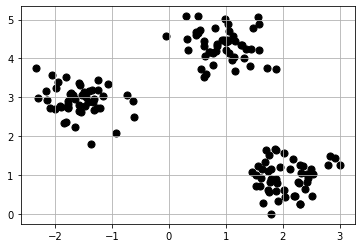

In [17]:
%matplotlib inline
# Importando make blobs e matplotlib
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Criando blobs (dados aleatórios em torno de centros definidos)
X,y = make_blobs(n_samples=150,
                 n_features=2,
                 centers=3,
                 cluster_std=0.4,
                 shuffle=True,
                 random_state=0)

# Plotando os blobs
plt.scatter(X[:,0],
            X[:,1],
            c='black',
            marker='o',
            s=50)

plt.grid()
plt.show()

Podemos usar KMeans do sklearn para realizar clusterização entre nosso conjunto de dados construído

In [18]:
# Importando o KMeans
from sklearn.cluster import KMeans

# Criando o objeto KMeans 
# Observe que já sabemos a priori quantos clusters precisaremos
num_clusters = 3
km = KMeans(n_clusters=num_clusters)

# Performando clusterização K-means
cluster_km = km.fit_predict(X)

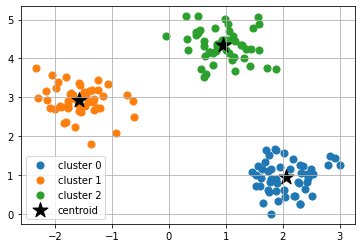

In [19]:
# Plotando os dados com cores para o cluster
for cluster in range(num_clusters):
        plt.scatter(X[cluster_km==cluster,0],
                    X[cluster_km==cluster,1],
                    s=50,
                    cmap='Pastel1',
                    label='cluster {}'.format(cluster))

# Plotando o centro dos CLusters
plt.scatter(km.cluster_centers_[:,0],
            km.cluster_centers_[:,1],
            s=250,
            c='black',
            marker='*',
            label='centroid')

plt.legend()
plt.grid()
plt.show()

Embora k-means funcione bem neste conjunto de dados, precisamos ressaltar alguns dos
principais desafios do k-means. Uma das desvantagens do k-means é que temos que
especificar o número de clusters k a priori, o que pode nem sempre ser tão óbvio em
aplicações do mundo real, especialmente se estivermos trabalhando com uma dimensão mais elevada do
conjunto de dados que não pode ser visualizado. As outras propriedades do k-means são que os clusters
não se sobrepõem e não são hierárquicos, e também assumimos que há pelo menos
um item em cada cluster.

#### Métodos de Validação - Curva do cotovelo

A fim de quantificar a **qualidade da clusterização**, precisamos usar métricas intrínsecas, como o SSE dentro do cluster (distorção) que discutimos anteriormente neste capítulo - para comparar o desempenho de diferentes agrupamentos k-means.
Convenientemente, não precisamos calcular o SSE dentro do cluster explicitamente, pois é já acessível através do atributo ``inertia`` após fazer o fit de um modelo KMeans:

In [20]:
print('Distorção: %.2f' % km.inertia_)

Distorção: 46.38


Com base no SSE dentro do cluster, podemos usar uma ferramenta gráfica, o chamado método do cotovelo, para estimar o número ótimo de clusters k para uma determinada tarefa. Intuitivamente,
podemos dizer que, se k aumentar, a distorção diminuirá. Isso ocorre porque as amostras estarão mais próximas dos centróides aos quais estão atribuídas. A ideia por trás do
método do cotovelo é identificar o valor de k onde a distorção começa a aumentar
mais rapidamente, o que ficará mais claro se traçarmos a distorção para diferentes
valores de k:

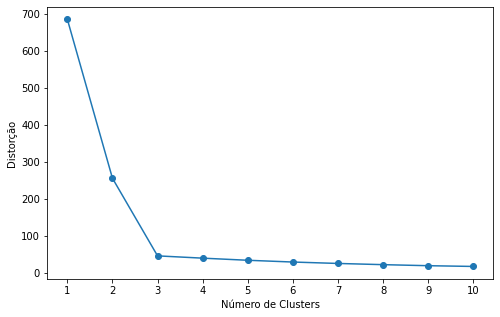

In [21]:
# Criando lista vazia
distortions = []

# Cálculo da distorção para uma série de valores de k
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)
    
# Gráfico da Distorção
plt.figure(figsize=(8,5))
plt.plot(range(1,11), distortions, marker='o')
plt.xticks(range(1,11))
plt.xlabel('Número de Clusters')
plt.ylabel('Distorção')
plt.show()

Como podemos ver no gráfico a seguir, o cotovelo está localizado em k = 3, o que fornece
evidência de que k = 3 é de fato uma boa escolha para este conjunto de dados.

#### Coeficiente de Silhueta

A análise da silhueta pode ser usada para medir a coesão do cluster entre os pontos de dados e o centróide. Para o cálculo, tem-se o passo a passo:
1. Calcule a coesão do cluster $a_ {i}$ como a distância média entre uma amostra $x_ {i}$ e todos os outros pontos no mesmo cluster.
2. Calcule a separação de cluster $b_ {i}$ do próximo cluster mais próximo como a distância média entre a amostra $x_ {i}$ e todas as amostras no cluster mais próximo.
3. Calcule a silhueta $s_ {i}$ como a diferença entre a coesão e a separação do cluster dividida pelo maior dos dois, conforme mostrado aqui:

 \begin{equation*}
s_{i} = \frac{b_{i} - a_{i}}{max\left \{ b_{i},a_{i} \right \}}
\end{equation*}

O coeficiente de silhueta é limitado no intervalo de -1 a 1. Com base na fórmula anterior, podemos ver que o coeficiente de silhueta é 0 se a separação e coesão do cluster forem iguais ($ b_ {i} = a_ {i} $). Além disso, chegamos perto de um coeficiente de silhueta ideal de 1 se ($ b_ {i} >> a_ {i} $), uma vez que $ b_ {i} $ quantifica quão diferente é uma amostra de outros clusters, e $ a_ {i } $ nos diz o quão semelhante são as outras amostras em seu próprio cluster.

O coeficiente de silhueta está disponível como ```silhouette_score``` no módulo ```sklearn.metrics```. Isso calcula o coeficiente de silhueta médio em todas as amostras, que é equivalente a numpy.mean (silhouette_samples (…)).

Para melhor ilustrar esta importante métrica, você pode executar as 2 células a seguir e alterar a dispersão dos dados no widget ```cluster_cohesion```. Não se preocupe se você não entender parte do código que usamos aqui para fazer o plot.

In [23]:
# Importando Python widgets para construit o plot interativo
# Execute o comando comentado abaixo, caso tenha problema no import
# !jupyter nbextension enable --py widgetsnbextension

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [24]:
# Importando silhouette_score
from sklearn.metrics import silhouette_score

# Declarando esta função para ser iteraiva
@interact
def calculate_kmeans(Dispersao=(0.1,0.8,0.1), n_cluster=(2,5,1)):
    # Criando os blobs
    X,y = make_blobs(n_samples=500,
                 n_features=2,
                 centers=3,
                 cluster_std=Dispersao,
                 shuffle=True,
                 random_state=0)

    km = KMeans(n_clusters=n_cluster)
    
    # Clusterização K-Means 
    cluster_km = km.fit_predict(X)
    score = silhouette_score(X,
                             km.labels_,
                             metric='euclidean')
    
    print("SSE: {}, Coeficiente de Silhueta: {}".format(km.inertia_,score))
    
    # Plotando os CLusters
    plt.figure(figsize = (8,5))
    for cluster in range(n_cluster):
        plt.scatter(X[cluster_km==cluster,0],
                    X[cluster_km==cluster,1],
                    s=50,
                    cmap='Pastel1',
                    marker='s',
                    label='cluster {}'.format(cluster))
    
    # Plotando o centro dos clusters
    plt.scatter(km.cluster_centers_[:,0],
                km.cluster_centers_[:,1],
                s=250,
                c='black',
                marker='*',
                label='centroid')
    
    
    plt.legend()
    plt.grid()
    plt.show()

interactive(children=(FloatSlider(value=0.4, description='Dispersao', max=0.8, min=0.1), IntSlider(value=3, de…

Observe que, quando a dispersão dos dados é pequena (clusters são mais coesos), a pontuação da silhueta fica mais próxima de 1. <br>
E, mesmo se a dispersão for 0.1, mas o número do cluster não for 3, a pontuação sai de 1. <br>

Tente variar o número de clusters para cima e para baixo no widget e veja o que ocorre (não há a necessidade de alterar o código).
<br>
<br>
Portanto, este experimento mostra a importância de equilibrar o número correto de clusters usando algumas métricas de avaliação e como essa escolha afeta o desempenho do modelo.

### Exercicio 2

Agora que você aprendeu os conceitos de agrupamento Kmeans, vamos tentar usá-lo com nosso conjunto de dados de varejo para agrupar nossos clientes. Primeiro, precisamos tratar um pouco os dados e criar algumas features relacionadas ao cliente para que possamos utilizá-las com o algoritmo. Como não é o foco desta lição, não comentaremos muito sobre esta primeira parte.

In [25]:
# Criando preço por produto
df['Price'] = df.Quantity * df.UnitPrice

# Consolidando os itens em 1 cliente por linha.
product_features = (df.groupby(['CustomerID', 'Description'])['Quantity']
                    .sum().unstack().reset_index().fillna(0)
                    .set_index('CustomerID'))

# Certifique-se de que todos os valores positivos sejam convertidos em 1 e qualquer valor menor que 0 seja definido como 0
product_presence = product_features.applymap(encode_units)

# Criando uma coluna para quantidade total e número de produtos
product_features["total"] = product_features.sum(axis = 1, skipna = True)
product_presence["total"] = product_presence.sum(axis = 1, skipna = True)

In [26]:
# Obtendo apenas os produtos mais comuns para reduzir o número de features
number_of_products = 10
most_common_products = df.Description.value_counts(sort=True)[0:number_of_products].index.tolist()
most_common_products.append("total")

product_features_filtered = product_features[most_common_products].add_suffix("_quantidade")
product_presence_filtered = product_presence[most_common_products].add_suffix("_numero")

product_features_filtered.head(10)

Description,WHITE HANGING HEART T-LIGHT HOLDER_quantidade,JUMBO BAG RED RETROSPOT_quantidade,REGENCY CAKESTAND 3 TIER_quantidade,PARTY BUNTING_quantidade,LUNCH BAG RED RETROSPOT_quantidade,ASSORTED COLOUR BIRD ORNAMENT_quantidade,SET OF 3 CAKE TINS PANTRY DESIGN_quantidade,PACK OF 72 RETROSPOT CAKE CASES_quantidade,LUNCH BAG BLACK SKULL._quantidade,NATURAL SLATE HEART CHALKBOARD_quantidade,total_quantidade
CustomerID,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74215.0
12347.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2458.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2341.0
12349.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,631.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.0
12352.0,0.0,0.0,5.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,536.0
12353.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
12354.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,530.0
12355.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0


In [27]:
# Calculando o numero de invoices por cliente
num_invoices = df.groupby('CustomerID').InvoiceNo.nunique().to_frame()
num_invoices.head()

,InvoiceNo
CustomerID,
12346.0,1
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [28]:
# Calculando o tempo desde o ultimo invoice
import numpy as np
last_invoice = df.groupby('CustomerID').InvoiceDate.max().to_frame()
last_invoice['time_from_last'] = (pd.to_datetime('today') - last_invoice['InvoiceDate']) / np.timedelta64(1,'D')
last_invoice.head()

,InvoiceDate,time_from_last
CustomerID,,
12346.0,2011-01-18 10:01:00,3787.508278
12347.0,2011-12-07 15:52:00,3464.264528
12348.0,2011-09-25 13:13:00,3537.374945
12349.0,2011-11-21 09:51:00,3480.515222
12350.0,2011-02-02 16:01:00,3772.258278


In [29]:
# Calculando a média de preços
invoicePrice = df.groupby(['CustomerID', 'InvoiceNo']).Price.sum().to_frame()
averagePrice = invoicePrice.groupby('CustomerID').Price.mean().to_frame()
averagePrice.head()

,Price
CustomerID,
12346.0,77183.600000
12347.0,615.714286
12348.0,449.310000
12349.0,1757.550000
12350.0,334.400000


In [30]:
# Consolidando variaveis
final_df = pd.merge(product_features_filtered, product_presence_filtered, on = 'CustomerID')
final_df = pd.merge(final_df, num_invoices, on = 'CustomerID')
final_df = pd.merge(final_df, last_invoice.drop(columns=['InvoiceDate']), on = 'CustomerID')
final_df = pd.merge(final_df, averagePrice, on = 'CustomerID')
final_df.head()

,WHITE HANGING HEART T-LIGHT HOLDER_quantidade,JUMBO BAG RED RETROSPOT_quantidade,REGENCY CAKESTAND 3 TIER_quantidade,PARTY BUNTING_quantidade,LUNCH BAG RED RETROSPOT_quantidade,ASSORTED COLOUR BIRD ORNAMENT_quantidade,SET OF 3 CAKE TINS PANTRY DESIGN_quantidade,PACK OF 72 RETROSPOT CAKE CASES_quantidade,LUNCH BAG BLACK SKULL._quantidade,NATURAL SLATE HEART CHALKBOARD_quantidade,total_quantidade,WHITE HANGING HEART T-LIGHT HOLDER_numero,JUMBO BAG RED RETROSPOT_numero,REGENCY CAKESTAND 3 TIER_numero,PARTY BUNTING_numero,LUNCH BAG RED RETROSPOT_numero,ASSORTED COLOUR BIRD ORNAMENT_numero,SET OF 3 CAKE TINS PANTRY DESIGN_numero,PACK OF 72 RETROSPOT CAKE CASES_numero,LUNCH BAG BLACK SKULL._numero,NATURAL SLATE HEART CHALKBOARD_numero,total_numero,InvoiceNo,time_from_last,Price
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74215.0,0,0,0,0,0,0,0,0,0,0,1,1,3787.508278,77183.600000
12347.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2458.0,0,0,1,0,0,0,0,0,0,0,103,7,3464.264528,615.714286
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2341.0,0,0,0,0,0,0,0,0,0,0,22,4,3537.374945,449.310000
12349.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,631.0,0,0,1,0,0,0,1,0,0,0,73,1,3480.515222,1757.550000
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.0,0,0,0,0,0,0,0,0,0,0,17,1,3772.258278,334.400000


In [31]:
from scipy import stats
# Remoção de Outliers
final_df_no_outliers = final_df[(np.abs(stats.zscore(final_df)) < 3).all(axis=1)]

In [32]:
# Scale para normalização
from sklearn.preprocessing import MinMaxScaler

# Iniciando scaler
scaler = MinMaxScaler()

# Aplicando scaler
final_df_no_outliers_scaled = pd.DataFrame(scaler.fit_transform(final_df_no_outliers))

# Mudando nome das colunas
final_df_no_outliers_scaled.columns = final_df_no_outliers.columns
final_df_no_outliers_scaled['CustomerID'] = final_df_no_outliers.index.tolist()
final_df_no_outliers_scaled.set_index('CustomerID', inplace = True)

final_df_no_outliers_scaled.head()

,WHITE HANGING HEART T-LIGHT HOLDER_quantidade,JUMBO BAG RED RETROSPOT_quantidade,REGENCY CAKESTAND 3 TIER_quantidade,PARTY BUNTING_quantidade,LUNCH BAG RED RETROSPOT_quantidade,ASSORTED COLOUR BIRD ORNAMENT_quantidade,SET OF 3 CAKE TINS PANTRY DESIGN_quantidade,PACK OF 72 RETROSPOT CAKE CASES_quantidade,LUNCH BAG BLACK SKULL._quantidade,NATURAL SLATE HEART CHALKBOARD_quantidade,total_quantidade,WHITE HANGING HEART T-LIGHT HOLDER_numero,JUMBO BAG RED RETROSPOT_numero,REGENCY CAKESTAND 3 TIER_numero,PARTY BUNTING_numero,LUNCH BAG RED RETROSPOT_numero,ASSORTED COLOUR BIRD ORNAMENT_numero,SET OF 3 CAKE TINS PANTRY DESIGN_numero,PACK OF 72 RETROSPOT CAKE CASES_numero,LUNCH BAG BLACK SKULL._numero,NATURAL SLATE HEART CHALKBOARD_numero,total_numero,InvoiceNo,time_from_last,Price
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,0.0,0.0,0.185185,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.195949,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321767,0.230769,0.005021,0.126331
12348.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.186618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066246,0.115385,0.200963,0.092189
12349.0,0.0,0.0,0.012346,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.050243,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.227129,0.000000,0.048575,0.360611
12350.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.015631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050473,0.000000,0.830470,0.068612
12352.0,0.0,0.0,0.061728,0.0,0.0,0.0,0.1250,0.0,0.0,0.0,0.042667,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.182965,0.269231,0.096284,0.064273


In [33]:
# Criação do Dataset final
customers_df = final_df_no_outliers_scaled.copy()

Agora que temos nosso conjunto de dados final ```customers_df``` criado, podemos plotar a distorção pelo número de clusters para escolher o melhor k.

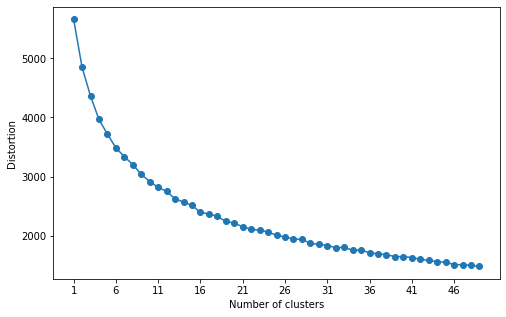

In [34]:
distortions_customers = []
max_clusters = 50

for i in range(1, max_clusters):
    km_customers = KMeans(n_clusters=i)
    km_customers.fit(customers_df)
    distortions_customers.append(km_customers.inertia_)
plt.figure(figsize=(8,5))
plt.plot(range(1,max_clusters), distortions_customers, marker='o')
plt.xticks(range(1,max_clusters,max_clusters//10))
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Agora, usando o gráfico da célula anterior, escolha o melhor número de clusters para usar em nosso modelo final abaixo. Como agora temos um problema real, tente usar não apenas a regra do cotovelo, mas também algum conhecimento de negócios para decidir o número de clusters. Por exemplo, devemos ter 50 clusters diferentes? Isso ajudaria em nossa operação?

In [36]:
from sklearn.cluster import KMeans

#Criaçao do Objeto
num_clusters = ___
km_customers = ___

#Realizando Clusterização
cluster_km_customers = km_customers.fit_predict(customers_df)

#Plotando distorção
print('Distortion: %.2f' % km_customers.inertia_)

AttributeError: ignored

Como temos muitos dados com muitas dimensões (features), vamos apenas traçar um histograma do número de clientes por cluster.

In [37]:
# Quantidade de Clientes por Cluster
plt.hist(x=cluster_km_customers, bins=num_clusters)
plt.show()

NameError: ignored

Agora que os clusters já estão montados, tente interpreta-los:
* Quais são as peculiaridades de cada cluster ?
* Qual é a caracteristica mais forte de cada um ?

Sinta-se a vontade para revisitar a aula de EDA caso necessite de ajuda para montar as análises    

<a id="modeling_clustering"></a>
### 3.4. Clusterização Hierárquica

Vamos dar uma olhada em uma abordagem alternativa para clusterização: **Clusterização hierárquica**.

Esta técnica é uma altenativa a anterior já que possui um mecanismo diferente para a montagem dos clusters. Esta técnica baseia-se na união das amostras para a montagem do cluster, ou na divisão sequencial do conjunto de todas as amostras para a formação dos clusters (explicaremos melhor abaixo).

Uma das vantagens desta técnica é que nos permite traçar dendrogramas (visualizações de um agrupamento hierárquico binário), o que pode ajudar na interpretação dos resultados já que nos permite entender o processo de formação/divisão dos clusters.
Outra vantagem útil dessa abordagem hierárquica é que não precisamos especificar o número de clusters antecipadamente.

As duas principais abordagens para agrupamento hierárquico são  o **aglomerativo e  o divisivo**:

* **Divisivo**: começa com um cluster que abrange todas as nossas amostras e divide iterativamente o cluster em clusters menores até que cada um contenha apenas uma amostra.

* **Aglomerativo**: adota a abordagem oposta, começando com cada amostra como um cluster individual e mesclando os pares mais próximos de clusters até que apenas um cluster permaneça.

Nesta seção, vamos nos concentrar no agrupamento aglomerativo, pois é mais comum e útil para obter insights.

Os dois algoritmos padrão para agrupamento hierárquico aglomerativo são os de **Simple Linkage** e **Complete Linkage**.

* **Simple Linkage**: calculamos as distâncias entre os membros mais semelhantes para cada par de clusters e fundimos os dois clusters para os quais a distância entre os membros mais semelhantes é a menor.

* **Complete Linkage**: é semelhante à Simple Linkage, mas, em vez de comparar os membros mais semelhantes em cada par de clusters, comparamos os membros mais diferentes para realizar a fusão.

Outros algoritmos comumente usados para agrupamento hierárquico aglomerativo incluem **average linkage** e **Ward's linkage**. No average linkage, mesclamos os pares do cluster com base nas distâncias médias mínimas entre todos os membros do grupo nos dois clusters. No Ward's linkage, os dois clusters que levam ao aumento mínimo do SSE total dentro do cluster são mesclados.

**Método Aglomerativo:**

Este é um procedimento iterativo que pode ser resumido pelo
seguintes passos:

1. Calcule a matriz de distância de todas as amostras.
2. Represente cada ponto de dados como um cluster singleton.
3. Mescle os dois clusters mais próximos com base na distância dos membros mais diferentes (distantes).
4. Atualize a matriz de distância.
5. Repita as etapas 2 a 4 até que um único cluster permaneça.

![img](https://dashee87.github.io/images/hierarch.gif)

Vamos usar a biblioteca ```scipy``` para traçar um dendograma e visualizar o número de clusters que podem se ajustar melhor aos nossos dados e mostrar```AgglomerativeClustering``` de ``` sklearn``` para computar facilmente os clusters.

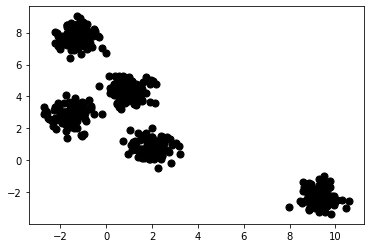

In [38]:
#Gerando amostra com 5 clusters
X,y = make_blobs(n_samples=500,
             n_features=2,
             centers=5,
             cluster_std=0.5,
             shuffle=True,
             random_state=0)

# Gráfico
plt.scatter(X[:,0],
            X[:,1],
            c="black",
            marker='o',
            s=50)

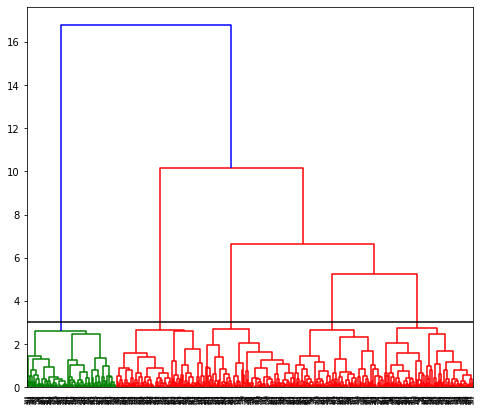

In [39]:
# Importando libs
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

# Criação do cluster hierarquico
linked = linkage(X, method='complete', metric='euclidean', optimal_ordering=True)

# Dendograma
plt.figure(figsize=(8, 7))  
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

h_line = 3
plt.axhline(y=h_line, c='k')
plt.show() 

Este dendrograma nos mostra que temos uma grande diminuição na distância global ao quebrar de 1 para 2 clusters, e também de 2 para 3, e assim por diante até chegarmos de 4 para 5 clusters (aqueles acima da linha horizontal quando ```hline = 3```). Então, a partir de 6 clusters, as distâncias quando adicionamos mais um cluster são muito semelhantes. Isso nos diz, semelhante à regra do cotovelo, que o número de clusters a serem usados aqui é 5.

Agora podemos usar ``AgglomerativeClustering`` para separar nossos dados.

In [40]:
# Importando AgglomerativeClustering e StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Criação do objeto Agglomerative Clustering
ac = AgglomerativeClustering(affinity='euclidean',linkage='ward', n_clusters=5)

# Fitting e predicting
cluster_ac = ac.fit_predict(X)

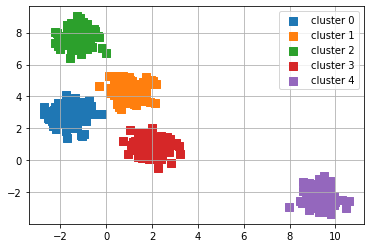

In [41]:
# Clusters com cores
for cluster in range(ac.n_clusters):
        plt.scatter(X[cluster_ac==cluster,0],
                    X[cluster_ac==cluster,1],
                    s=50,
                    cmap='Pastel1',
                    marker='s',
                    label='cluster {}'.format(cluster))

plt.legend()
plt.grid()
plt.show()


### Exercicio 3

Vamos tentar usar o clustering hierárquico para nosso conjunto de dados de varejo.

In [42]:
# Criação do Cluster Hierarquico
linked_customers = linkage(customers_df, method='complete', metric='euclidean', optimal_ordering=True)

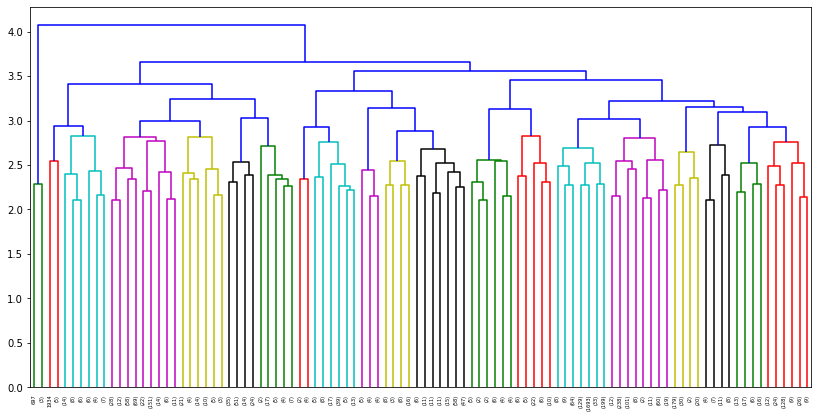

In [43]:
# Dendograma
plt.figure(figsize=(14, 7))  
dendrogram(linked_customers,
           truncate_mode='lastp',         # usamos o modo truncado para que possamos definir um número máximo p de clusters para mostrar
           p=100,                         # definindo p como 100 para tornar o gráfico mais fácil de ler
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

plt.show() 

#### Parte 1
Assim como no KMeans, utilize o gráfico anterior para definir o número de clusters. Em seguida, aplique o ``AgglomerativeClustering`` e plote o histograma dos clientes em cada cluster.

In [55]:
# Criando o objeto AgglomerativeClustering
ac_customers = AgglomerativeClustering(affinity='euclidean',linkage='ward', n_clusters=5)

# Fitting e predicting
cluster_ac_customers = ac_customers.fit_predict(X)


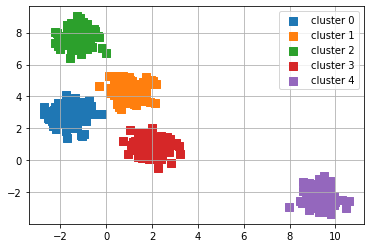

In [56]:
# Mostrando a quantidade de clientes por clusters
for cluster in range(ac_customers.n_clusters):
        plt.scatter(X[cluster_ac_customers==cluster,0],
                    X[cluster_ac_customers==cluster,1],
                    s=50,
                    cmap='Pastel1',
                    marker='s',
                    label='cluster {}'.format(cluster))

plt.legend()
plt.grid()
plt.show()

#### Parte 2
Agora possuimos novos clusters! Analise e discuta as principais diferenças dos clusters obtidos com o método hierárquico e com o método anterior. 

<a id="soft_clustering_analysis"></a>
## 4. Soft Clustering

Nesta seção, apresentaremos a análise de Soft Clustering. Para isso, utilizaremos a base de dados 2018_medias_jogadores.xlsx. Ela é baseada no Cartola FC, que é um jogo que deixa os torcedores muito mais próximos da função de técnico e de diretor de um clube da Série A do Campeonato Brasileiro. O cartoleiro tem como missão escalar seu time a cada rodada do Campeonato Brasileiro, considerando que alguns atletas podem estar lesionados, suspensos ou em condições incertas para entrar em campo na próxima partida. Além disso, cada atleta apresenta diferentes atributos que podem ajudar o cartoleiro a escalar o time da melhor maneira possível, sabendo que cada jogador tem seu preço (medido em cartoletas, moeda oficial do jogo).

<a id="problem_definition_soft_clustering"></a>
### 4.1. Definição do Problema

Suponha que você seja um jogador do Cartola FC e você não escolheu o time da sua semana. Então imagine o seguinte cenário: você está ficando sem dinheiro e por isso não consegue escolher o jogador que está acostumado. Então você se pergunta: _"Que jogador devo escolher?"_.

Este é um exemplo de problema que pode ser resolvido usando uma técnica de análise de Clusterização. Por exemplo, poderíamos agrupar os jogadores com as mesmas características e, entre aqueles que são semelhantes ao avatar a que está habituado, poderíamos escolher outro com preço inferior.

In [57]:
# Importando as Bibliotecas e as base de dados
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

df_orig = pd.read_excel('/mydrive/dados/2018_medias_jogadores.xlsx')
df_orig = shuffle(df_orig).reset_index(drop = True)
df_orig.head()

,player_id,player_slug,price_cartoletas,descritivo_jogador,time,player_team,player_position,position_id,score_mean,score_no_cleansheets_mean,diff_home_away_s,n_games,score_mean_home,score_mean_away,shots_x_mean,fouls_mean,RB_mean,PE_mean,A_mean,I_mean,FS_mean,FF_mean,G_mean,DD_mean,DP_mean
0,80337,arthur,8.66,"arthur, Chapecoense, ata, Média:4,7, Preço:8,66",Chapecoense,315,ata,5,4.700000,4.700000,0.807618,11,5.880000,3.716667,1.818182,2.090909,0.909091,2.000000,0.000000,0.090909,2.181818,1.181818,0.363636,0.000000,0.000000
1,68821,rafael-galhardo,2.65,"rafael-galhardo, Vasco, lat, Média:0,85, Preço...",Vasco,267,lat,2,0.850000,0.850000,0.330073,10,1.733333,0.471429,1.100000,1.000000,0.700000,2.800000,0.000000,0.100000,0.900000,0.700000,0.000000,0.000000,0.000000
2,81881,joao-ricardo,6.49,"joao-ricardo, América-MG, gol, Média:3,0892857...",América-MG,327,gol,1,3.089286,4.160714,-0.716338,28,3.981818,2.180000,0.000000,0.071429,0.000000,0.892857,0.000000,0.000000,0.071429,0.000000,0.000000,1.428571,0.035714
3,78497,arnaldo,4.33,"arnaldo, Ceará, lat, Média:2,881818182, Preço:...",Ceará,204,lat,2,2.881818,0.609091,0.466803,11,3.800000,1.780000,0.000000,0.727273,0.727273,1.454545,0.000000,0.000000,1.181818,0.000000,0.000000,0.000000,0.000000
4,74074,claudio-winck,4.63,"claudio-winck, Sport, lat, Média:3,114285714, ...",Sport,292,lat,2,3.114286,1.923810,0.678708,21,4.570000,1.650000,1.476190,2.428571,1.142857,3.047619,0.047619,0.190476,1.095238,0.952381,0.142857,0.000000,0.000000


<a id="initial_analysis_soft_clustering"></a>
### 4.2. Análises Iniciais

A principal diferença entre os métodos tradicionais de clustering (o que chamamos de hard clustering) e o soft clustering são os componentes de cada cluster. No Hard Clustering, cada ponto no conjunto de dados pertence a apenas um cluster, enquanto no Soft Clustering cada ponto tem uma probabilidade de estar em um determinado cluster. Em outras palavras, o agrupamento é flexível a ponto de permitir que um item possa existir em "vários clusters".

No nosso caso, imagine que estamos acostumados a escolher o jogador Lucas Lima, meio-campista do Palmeiras, que vale 8,22 cartoletas. Infelizmente esta semana não podemos pagar este valor. Suponha que usamos um método de agrupamento para descobrir quem são os jogadores semelhantes ao Lucas Lima e seus preços. Podemos ver algumas boas opções mais baratas que Lucas Lima no cluster, então podemos inferir que se pegarmos Everton Ribeiro, por exemplo, há uma grande chance de termos um score semelhante pagando menos cartoletas. 

![img](https://i.imgur.com/RGbY0Ua.png)

Se este problema fosse resolvido usando um método de hard clustering e analisássemos o cluster de Everton Ribeiro, o cluster seria exatamente igual ao de Lucas Lima (mostrado acima). Por outro lado, se escolhermos um método de Soft Clustering, para cada avatar haveria um cluster específico com os mais semelhantes entre eles. Dê uma olhada em um possível soft cluster para Everton Ribeiro e observe que o cluster não é exatamente o mesmo que o de Lucas Lima.

![img](https://i.imgur.com/bG2Ta2m.png)

O soft clustering nos traz um cluster mais customizado para cada jogador analisado, já que cada jogador tem uma probabilidade de ser semelhante a todos os outros jogadores no jogo de fantasia.

<a id="modeling_soft_clustering"></a>
### 4.3. Modelagem

Não existe apenas uma implementação da técnica Soft Clustering. Nesta seção, apresentamos uma (das muitas possíveis) implementação baseada no modelo Random Forest. Portanto, para implementá-lo, primeiro precisamos importar todos os pacotes necessários do ```scikit-learn```.

In [58]:
# Importando Bibliotecas
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor

Além disso, precisamos separar nossas variáveis X e y. Mas, para fazer isso, existem algumas features no conjunto de dados que não devem ser considerados na clusterização. Por exemplo, algumas características categóricas e outras que podem ser extremamente correlacionadas ao preço dos jogadores (relação de causa e efeito).

In [59]:
# Eliminando Variaveis Desnecessárias
cols_to_drop = ['player_position','score_no_cleansheets_mean']
df = df_orig.drop(cols_to_drop, axis=1)
df.head(5)

# Removendo possíveis variáveis de causa e efeito e removendo outras categóricas
cols_possible_cause_effect = ['score_mean','diff_home_away_s','score_mean_home','score_mean_away']
X = df.copy()
X.drop(cols_possible_cause_effect, axis=1, inplace=True)
X = X.loc[:, 'position_id' : 'DP_mean'].fillna(0)

# Obtendo a váriavel Y
y = df['price_cartoletas']

Agora que os dados estão estruturados corretamente, podemos modelar nosso problema usando a implementação ``scikit-learn`` Random Forest.

In [60]:
# Gerando o Modelo de Random Forest
rfr = RandomForestRegressor(n_estimators=500, criterion='mse', min_samples_leaf=5)

# Fit
rfr.fit(X, y)

# Obtendo a importância das variaveis
importances = pd.Series(index=X.columns, data=rfr.feature_importances_)
importances.sort_values(ascending=False, inplace=True)
print('Variable importances:\n',importances)

Variable importances:
 shots_x_mean    0.218586
n_games         0.193263
RB_mean         0.155168
G_mean          0.101006
A_mean          0.093530
FS_mean         0.070009
position_id     0.052566
PE_mean         0.043450
fouls_mean      0.034301
FF_mean         0.018376
I_mean          0.015696
DD_mean         0.003481
DP_mean         0.000568
dtype: float64


A implementação parte da ideia de que, para cada jogador, obtemos uma lista de outros jogadores semelhantes ao que foi analisado. Isso pode ser alcançado criando uma matriz dissimilar - esta matriz fornece uma estimativa grosseira da distância entre as amostras com base na proporção de vezes que as amostras terminam no mesmo nó de folha na floresta aleatória (não se preocupe com estes detalhes mais técnicos, explicaremos melhor nas próximas aulas).

In [61]:
# Obtendo Folhas
leaves = rfr.apply(X)
print('\nNº Folhas:\n', leaves, '\n\nDimensão das Folhas:', leaves.shape)

# Construindo a matriz de dissimilaridade
M = leaves.copy()
M = OneHotEncoder().fit_transform(M)
M = (M * M.transpose()).todense()
M = 1 - M / M.max()
print('\nMatriz de Dissimilaridade:\n', M, '\n\nDimensão da Matriz:', M.shape)


Nº Folhas:
 [[83 41 40 ... 54 75 83]
 [12 20 10 ... 11 14 20]
 [55  6 51 ... 64 11  7]
 ...
 [12 22 11 ... 15 24 19]
 [10 15 10 ... 10 14 10]
 [31 65 36 ... 50 67 55]] 

Dimensão das Folhas: (426, 500)

Matriz de Dissimilaridade:
 [[0.    0.994 1.    ... 0.998 1.    0.996]
 [0.994 0.    1.    ... 0.886 0.854 1.   ]
 [1.    1.    0.    ... 1.    0.992 1.   ]
 ...
 [0.998 0.886 1.    ... 0.    0.984 0.994]
 [1.    0.854 0.992 ... 0.984 0.    1.   ]
 [0.996 1.    1.    ... 0.994 1.    0.   ]] 

Dimensão da Matriz: (426, 426)


Observe que, na matriz de dissimilaridade, cada linha *i* e cada coluna *j* representa um jogador. Portanto, o valor (*i*, *j*) é dado pela frequência com que o jogador *i* e o jogador *j* terminaram no mesmo nó folha no Modelo Random Forest (o que significa que eles são similares). Agora, estamos quase prontos para responder ao nosso problema. Mas primeiro, vamos construir nossa estrutura de cluster!

In [62]:
# Construindo Clusters
size_of_cluster = 5
neighboors = []
distances = []
for i in range(len(leaves)):
    s = pd.Series(np.array(M[i])[0])
    s.drop(i, inplace=True)
    # Ordenando os Jogadores
    s.sort_values(ascending=True, inplace=True)
    neighboors.append([i] + list(s[:size_of_cluster].index))
    distances.append([0] + list(s[:size_of_cluster].values))
    
# Salvando Cluster na estrutura
clusters = {}
for i in range(len(neighboors)):
    L = []
    for j in range(len(neighboors[i])):
        L.append([neighboors[i][j], y[neighboors[i][j]]])
        clusters['C' + str(i)] = L
        
# Função usada para responder à pergunta: "Quais são os jogadores semelhantes ao Lucas Lima?"
def getCluster(df, clusters, search_variable, key=None, index=None):
    if index == None:
        index = df[df[search_variable] == key].index[0]
    return df.iloc[[e[0] for e in clusters['C' + str(index)]]]

Agora está tudo pronto! Use a célula abaixo para verificar os clusters de cada um dos possíveis jogadores!

In [63]:
getCluster(df=df, clusters=clusters, search_variable='player_slug', key='lucas-lima')

,player_id,player_slug,price_cartoletas,descritivo_jogador,time,player_team,position_id,score_mean,diff_home_away_s,n_games,score_mean_home,score_mean_away,shots_x_mean,fouls_mean,RB_mean,PE_mean,A_mean,I_mean,FS_mean,FF_mean,G_mean,DD_mean,DP_mean
118,80583,lucas-lima,8.22,"lucas-lima, Palmeiras, mei, Média:3,160606061,...",Palmeiras,275,4,3.160606,0.846630,33,4.442857,2.205882,0.787879,2.060606,1.545455,2.393939,0.090909,0.181818,1.484848,0.454545,0.151515,0.0,0.0
127,51772,everton-ribeiro,6.93,"everton-ribeiro, Flamengo, mei, Média:4,114285...",Flamengo,262,4,4.114286,0.598971,35,4.781250,3.011765,1.371429,1.542857,1.514286,3.885714,0.142857,0.057143,1.800000,0.685714,0.171429,0.0,0.0
181,54395,elias,6.32,"elias, Atlético-MG, mei, Média:3,308823529, Pr...",Atlético-MG,282,4,3.308824,0.919751,36,4.725000,2.350000,0.882353,1.382353,1.441176,2.088235,0.117647,0.147059,1.088235,0.529412,0.147059,0.0,0.0
330,73515,gabriel,6.74,"gabriel, Sport, mei, Média:2,909090909, Preço:...",Sport,292,4,2.909091,1.344225,33,4.720000,1.293750,0.909091,0.848485,0.727273,2.242424,0.090909,0.090909,1.757576,0.424242,0.151515,0.0,0.0
156,80129,jadson,7.50,"jadson, Fluminense, mei, Média:2,003030303, Pr...",Fluminense,266,4,2.003030,1.122165,33,3.413333,0.656250,0.575758,1.454545,1.454545,3.181818,0.030303,0.090909,1.606061,0.272727,0.060606,0.0,0.0
363,63289,edenilson,9.24,"edenilson, Internacional, mei, Média:2,834375,...",Internacional,285,4,2.834375,1.583849,32,4.550000,0.921429,0.625000,1.312500,1.375000,2.281250,0.156250,0.062500,1.281250,0.375000,0.093750,0.0,0.0


Parabéns! Você conseguiu obter uma lista de jogadores similares a Lucas Lima, o que lhe permite escolher um que tenha um custo menor.

<a id="pan"></a>
## Fim da Aula!
Com a conclusão desta aula esperamos que você esteja mais familiarizado com os conceitos de Aprendizagem não Supervisionada!
Na próxima aula iremos abordar o outro lado da moeda, ou seja, o Aprendizado Supervisionado! Iremos elucidar alguns conceitos e técnicas associados aos problemas de Classificação!

Até a próxima aula!!